<a href="https://colab.research.google.com/github/HannaRF/DeepLearning/blob/main/ap3_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Session 3 - Transfer Learning

In this practical session, we will explore the behavior of pre-trained networks compared to networks with randomly initialized weights. We will use the ResNet34 pre-trained on ImageNet as a basis to understand the effectiveness of *transfer learning*. Additionally, we will cover the concept of layer freezing, which will allow us to train a reduced number of parameters, focusing only on the most important parts of the network for the new task.


![resnet34](https://editor.analyticsvidhya.com/uploads/38371XTo6Q.png)

## Importing Libraries

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch

import requests
import zipfile

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

import torch.nn as nn
import torchvision.models as models
from torchsummary import summary


## Set the GPU


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## Donwload an Unzip the Data

In [3]:

# Define URL and paths
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = 'cats_and_dogs_filtered.zip'
extract_path = 'cats_and_dogs_filtered'

# Download the dataset
response = requests.get(_URL)
with open(zip_path, 'wb') as f:
    f.write(response.content)

# Extract the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

# Define paths to the dataset directories
train_dir = os.path.join(extract_path, 'train')
validation_dir = os.path.join(extract_path, 'validation')

print(f"Training data directory: {train_dir}")
print(f"Validation data directory: {validation_dir}")

# Optionally, verify the paths
assert os.path.exists(train_dir), "Training directory does not exist."
assert os.path.exists(validation_dir), "Validation directory does not exist."

Training data directory: cats_and_dogs_filtered/train
Validation data directory: cats_and_dogs_filtered/validation


## Load and preprocessing

In [4]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Define the data augmentation transforms
data_augmentation = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),  # Horizontal flip with probability 0.5
    transforms.RandomRotation(degrees=20),  # Random rotation between -20 and 20 degrees
    transforms.RandomResizedCrop(size=150, scale=(0.85, 1.0)),  # Randomly crop and resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


# Load the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=data_augmentation)
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=transform)


# Define the size of the test dataset (half of validation dataset)
val_size = len(validation_dataset)
test_size = val_size // 2
remaining_val_size = val_size - test_size

# Split the validation dataset into test and remaining validation datasets
test_dataset, remaining_val_dataset = random_split(validation_dataset, [test_size, remaining_val_size])

# Create data loaders for the test and remaining validation datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validation_loader = DataLoader(remaining_val_dataset, batch_size=32, shuffle=False)



## Show some examples

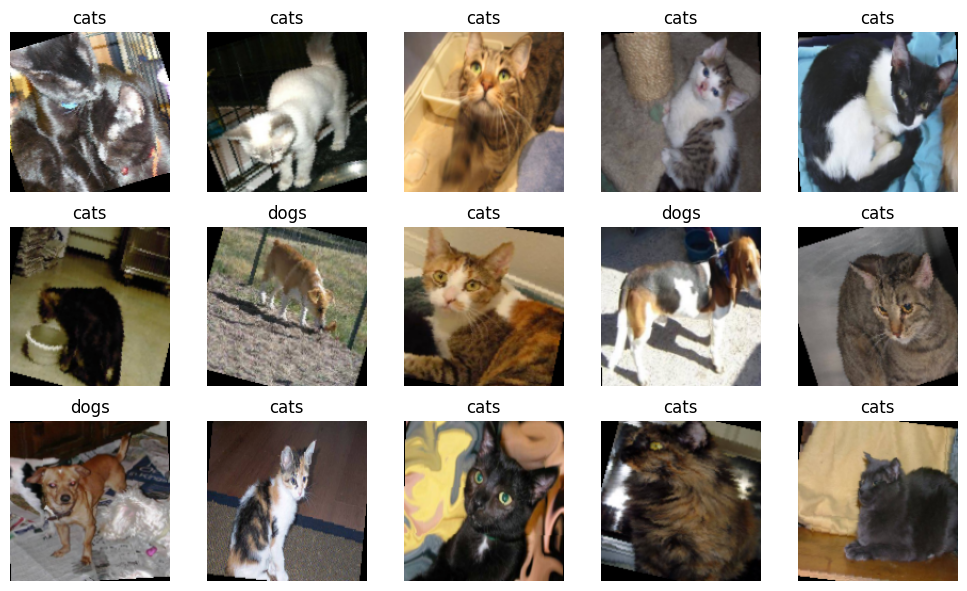

In [5]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define the inverse normalization transformation
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)
    tensor = tensor * std + mean
    return tensor

# Function to plot images with labels
def imshow(img, title):
    img = to_pil_image(img)  # Convert tensor to PIL image
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Get a batch of images and labels
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Define class labels (replace with your actual class names)
class_names = train_dataset.classes

# Denormalize the images
denormalized_images = denormalize(images, mean, std)

# Number of images to display
num_images = 15  # 5x5 grid

# Ensure you have at least `num_images` images
if len(denormalized_images) < num_images:
    raise ValueError("Not enough images in the batch to display a 5x5 grid.")

# Plot a 5x5 grid of images
plt.figure(figsize=(10,6))  # Adjust figure size as needed
for i in range(num_images):
    plt.subplot(3, 5, i + 1)
    imshow(denormalized_images[i], class_names[labels[i]])
plt.tight_layout()
plt.show()

## Building the Neural Network

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNetTransferLearning(nn.Module):
    def __init__(self, num_classes):
        super(ResNetTransferLearning, self).__init__()
        # Load a pre-trained ResNet model
        self.resnet = models.resnet34(pretrained=True)

        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_features, 512),  # First dense layer
            nn.ReLU(),                    # Activation function
            nn.Dropout(0.5),              # Dropout layer
            nn.Linear(512, 256),          # Second dense layer
            nn.ReLU(),                    # Activation function
            nn.Linear(256, num_classes)   # Final output layer
        )

    def forward(self, x):
        return self.resnet(x)

    def freeze_until_layer(self, layer_name):
        """
        Freeze all parameters until the specified layer name.

        Parameters:
        - layer_name (str): The name of the layer until which parameters should be frozen.
        """
        layer_found = False

        # Iterar sobre as camadas do modelo
        for name, param in model.named_parameters():
            if layer_name in name:
                layer_found = True
            if not layer_found:
                param.requires_grad = False  # Congela as camadas até encontrar a desejada
            if layer_found:
                break  # Para de congelar quando encontra a camada


In [7]:
# Example usage
num_classes = len(train_dataset.classes)  # Number of classes in your dataset
model = ResNetTransferLearning(num_classes=num_classes).to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 106MB/s]


In [8]:
model.freeze_until_layer('layer4.1')

In [9]:
#layer names

# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

print(model)

ResNetTransferLearning(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

## Summary Model

In [10]:
summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          36,864
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
       BasicBlock-11           [-1, 64, 38, 38]               0
           Conv2d-12           [-1, 64, 38, 38]          36,864
      BatchNorm2d-13           [-1, 64, 38, 38]             128
             ReLU-14           [-1, 64,

## Training and Evaluation Functions

In [11]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct_train += predicted.eq(labels).sum().item()
        total_train += labels.size(0)

    # Calculate average loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct_train / total_train

    return train_loss, train_accuracy



In [12]:
def evaluate(model, data_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    # Disable gradient calculations during evaluation
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    # Calculate average loss and accuracy
    val_loss = running_loss / len(data_loader)
    val_accuracy = 100. * correct_val / total_val

    return val_loss, val_accuracy



In [13]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        Arguments:
        - patience: How many epochs to wait after the last improvement before stopping the training.
        - delta: Minimum change in validation loss to consider as an improvement.
        - path: Path to save the best model.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.epochs_without_improvement = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1
            if self.epochs_without_improvement >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True


## Defining Optimizers and Loss Criterion

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



## Training the Model

In [15]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Initialize EarlyStopping
early_stopping = EarlyStopping(patience=10, delta=0.001)

num_epochs = 50  # Define the number of epochs
best_val_loss = float('inf')

# Main training loop
for epoch in range(num_epochs):
    # Train the model for one epoch
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = evaluate(model, validation_loader, criterion, device)

    # Save the metrics for this epoch
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print metrics for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping check
    early_stopping(val_loss, model)

    # If early stopping is triggered, stop the training
    if early_stopping.early_stop:
        print("Early stopping at epoch", epoch+1)
        break

Epoch [1/50]
Train Loss: 0.2246, Train Accuracy: 90.30%
Validation Loss: 0.0900, Validation Accuracy: 96.40%
Epoch [2/50]
Train Loss: 0.1544, Train Accuracy: 93.70%
Validation Loss: 0.1125, Validation Accuracy: 94.80%


KeyboardInterrupt: 

## Losses and Accuracies

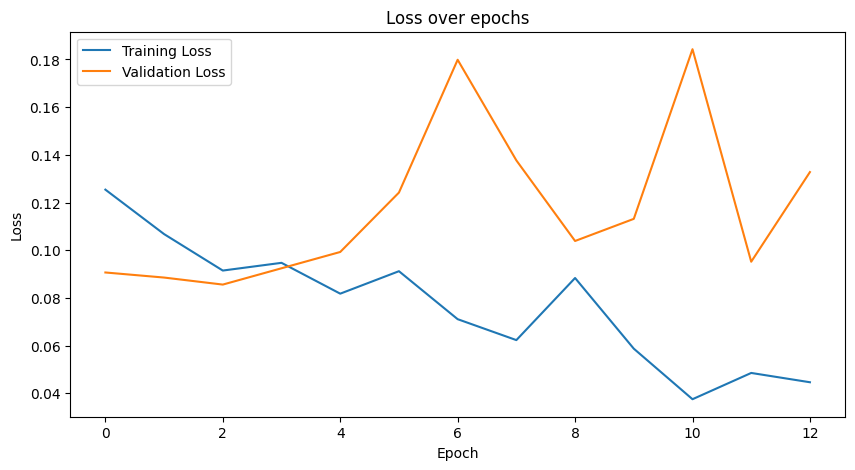

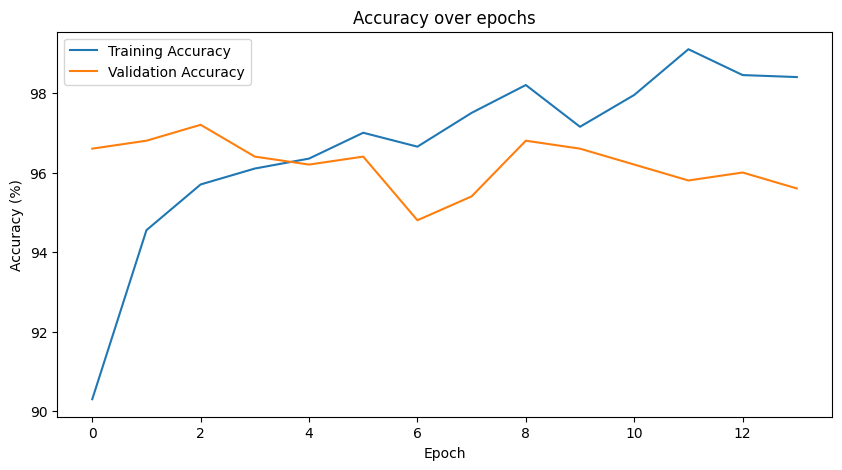

In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses[1:], label='Training Loss')
plt.plot(val_losses[1:], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

## Alguns Resultados

### From Scratch

![](https://drive.google.com/uc?export=view&id=1kIO_CbyHpyjCz9ZvuwBHdqwsJSAaiXhT)

![](https://drive.google.com/uc?export=view&id=15xRbAK-6y3Gm0jHXF_KXIn-q4GAz0YVy)

### Layer4.1

![](https://drive.google.com/uc?export=view&id=1y-GgC_edjCYrtc-Lfblip_XZLBFFeWdL)
![](https://drive.google.com/uc?export=view&id=1IdZy4qCh7CkyUKWKDTE2_SfEyPuqHF5U)



## Exercise

1. Train the model from scratch (random weight initialization).
2. Train the pre-trained ResNet34 model.
3. Freeze all layers up to `layer3.1` in the pre-trained model and fine-tune the rest.
4. Freeze all layers up to `layer4.1` in the pre-trained model and fine-tune the rest.
5. Freeze all layers up to the fully connected layer (`fc`) in the pre-trained model and fine-tune the remaining parameters.
